# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Цель исследования - определить рыночную стоимость объектов недвижимости.  

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Описание данных:**  
`airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)  
`balcony` — число балконов  
`ceiling_height` — высота потолков (м)  
`cityCenters_nearest` — расстояние до центра города (м)  
`days_exposition` — сколько дней было размещено объявление (от публикации до снятия)  
`first_day_exposition` — дата публикации  
`floor` — этаж  
`floors_total` — всего этажей в доме  
`is_apartment` — апартаменты (булев тип)  
`kitchen_area` — площадь кухни в квадратных метрах (м²)  
`last_price` — цена на момент снятия с публикации  
`living_area` — жилая площадь в квадратных метрах (м²)  
`locality_name` — название населённого пункта  
`open_plan` — свободная планировка (булев тип)  
`parks_around3000` — число парков в радиусе 3 км  
`parks_nearest` — расстояние до ближайшего парка (м)  
`ponds_around3000` — число водоёмов в радиусе 3 км  
`ponds_nearest` — расстояние до ближайшего водоёма (м)  
`rooms` — число комнат  
`studio` — квартира-студия (булев тип)  
`total_area` — общая площадь квартиры в квадратных метрах (м²)  
`total_images` — число фотографий квартиры в объявлении  

## Загрузка датасета и изучение общей информации

In [1]:
import os
import numpy as np
from numpy import floor

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
BASE_DIR = os.getcwd()
data = pd.read_csv(f'{BASE_DIR}\datasets\\real_estate_data.csv', sep='\t')
initial_data = data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

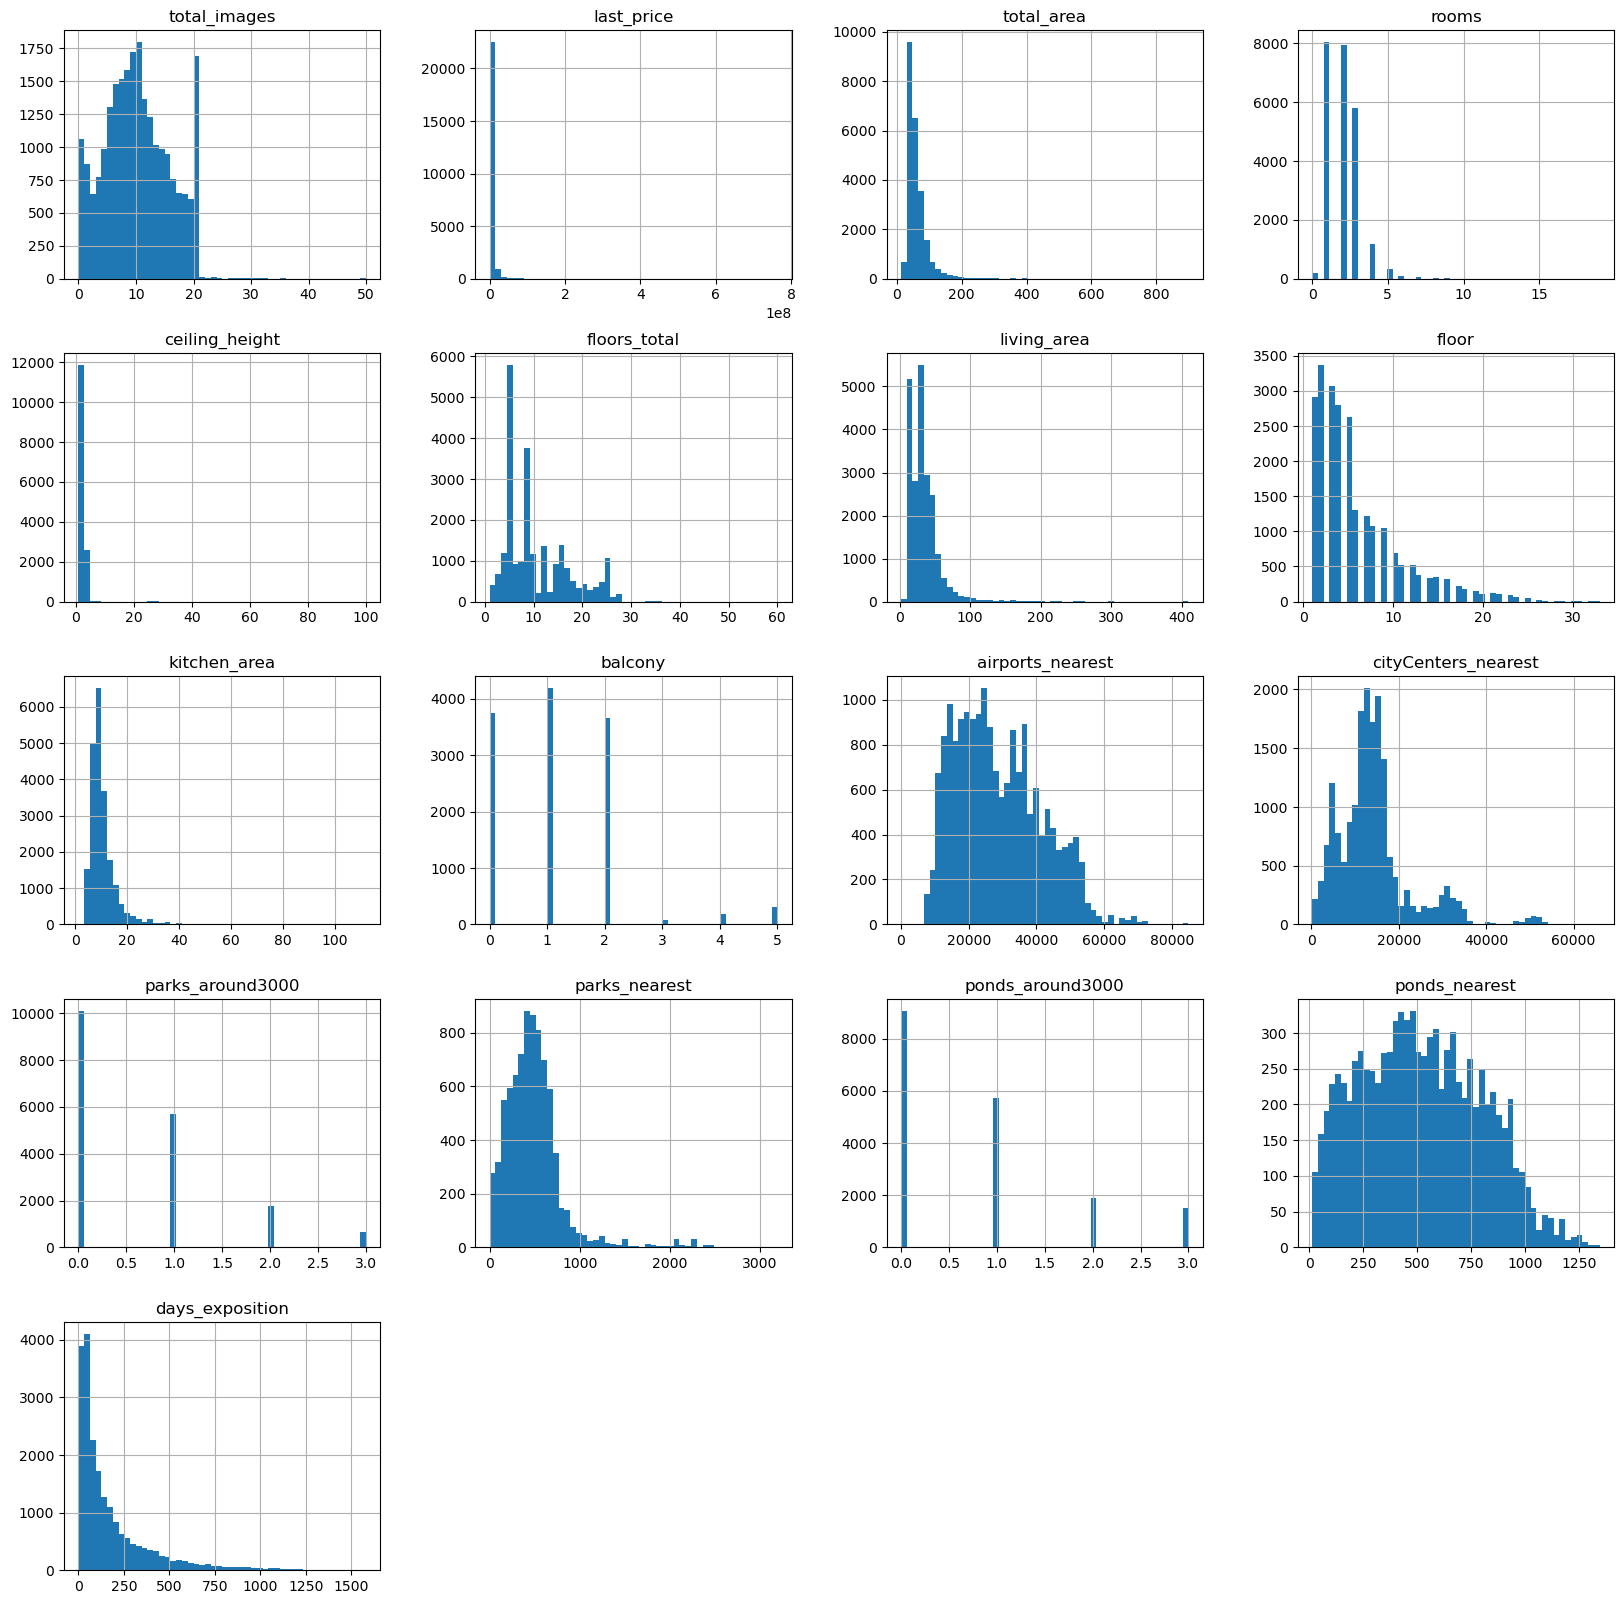

In [3]:
data.hist(bins=50, figsize=(20, 20));

In [4]:
pd.DataFrame(round(data.isna().mean()*100, 1)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.400000
living_area,8.000000
floor,0.000000
is_apartment,88.300000


In [5]:
[print(i) for i in sorted(data['locality_name'].astype(str).dropna().unique())];

nan
Бокситогорск
Волосово
Волхов
Всеволожск
Выборг
Высоцк
Гатчина
Зеленогорск
Ивангород
Каменногорск
Кингисепп
Кириши
Кировск
Колпино
Коммунар
Красное Село
Кронштадт
Кудрово
Лодейное Поле
Ломоносов
Луга
Любань
Мурино
Никольское
Новая Ладога
Отрадное
Павловск
Петергоф
Пикалёво
Подпорожье
Приморск
Приозерск
Пушкин
Санкт-Петербург
Светогорск
Сертолово
Сестрорецк
Сланцы
Сосновый Бор
Сясьстрой
Тихвин
Тосно
Шлиссельбург
городской поселок Большая Ижора
городской поселок Янино-1
городской посёлок Будогощь
городской посёлок Виллози
городской посёлок Лесогорский
городской посёлок Мга
городской посёлок Назия
городской посёлок Новоселье
городской посёлок Павлово
городской посёлок Рощино
городской посёлок Свирьстрой
городской посёлок Советский
городской посёлок Фёдоровское
городской посёлок Янино-1
деревня Агалатово
деревня Аро
деревня Батово
деревня Бегуницы
деревня Белогорка
деревня Большая Вруда
деревня Большая Пустомержа
деревня Большие Колпаны
деревня Большое Рейзино
деревня Большой Сабск
дере

На первый взгляд данные выглядят естественно, на графиках не видны сильно выбивающиеся значения.  
Типы данных столбцов требуют преобразования.  
В данных много пропусков, необходимо попытаться их заполнить.  
Также нужно проверить данные на предмет явных дубликатов, а именно дубликаты в столбце с названиями локаций.

## Предобработка данных

### Преобразование типов данных

In [6]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT00:00:00')
data['floors_total'] = data['floors_total'].astype('Int64')
data['balcony'] = data['balcony'].astype('Int64')
data['ceiling_height'] = data['ceiling_height'].astype(float)
data['parks_around3000'] = data['parks_around3000'].astype('Int64')
data['ponds_around3000'] = data['ponds_around3000'].astype('Int64')
data['days_exposition'] = floor(pd.to_numeric(data['days_exposition'], errors='coerce')).astype('Int64')

Типы данных столбцов приведены в соответствие с хранящимися в них данными

### Поиск и замена дубликатов

Из всех колонок с данными искать дубликаты имеет смысл только в колонке с названиями локаций.

In [7]:
locs = list(data['locality_name'].dropna().unique())

В первую очередь определим сколько уникальных значений изначально.  

In [8]:
data['locality_name_initial'] = data['locality_name']
print(len(data['locality_name'].unique()))

365


В списке населённых пунктов 365 уникальных значения.  
Проверим станет ли значений меньше если мы приведём все значения к одному регистру.

In [9]:
data['locality_name'] = data['locality_name'].str.lower()
print(len(data['locality_name'].unique()))

365


Уникальных значений меньше не стало. Попробуем заменить ё на е.

In [10]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.replace('Ё', 'Е')
print(len(data['locality_name'].unique()))

331


Число уникальных значений сократилось на 34.  
Теперь попробуем удалить названия типов населённых пунктов.

In [11]:
def mult_str_part_remove(dat, l):
    for s in l:
        dat = dat.str.replace(s, '')
    return dat

to_replace = ['деревня ',
              'поселок городского типа ',
              'село ',
              'городской поселок ',
              'коттеджный поселок ',
              'поселок имени ',
              'поселок городского типа имени ',
              'поселок станции ',
              'поселок при железнодорожной станции ',
              'садовое товарищество ',
              'садовое некоммерческое товарищество ',
              'садоводческое некоммерческое товарищество ',
              'поселок ']

data['locality_name'] = mult_str_part_remove(data['locality_name'], to_replace)

print(len(data['locality_name'].unique()))

# приведём к одному регистру
data['locality_name'] = data['locality_name'].str.capitalize()
data['locality_name'] = data['locality_name'].mask(data['locality_name'] == 'Санкт-петербург', 'Санкт-Петербург')


306


Уникальных значений стало ещё на 25 меньше.  
В итоге мы сократили число уникальных наименований с 365 до 306.

In [12]:
data.pivot_table(index='locality_name', values='locality_name_initial',aggfunc=('nunique', 'unique')).query('nunique > 1')

,nunique,unique
locality_name,,
Аннино,2,"[посёлок Аннино, поселок Аннино]"
Большая ижора,2,"[городской поселок Большая Ижора, поселок горо..."
Бугры,2,"[посёлок Бугры, поселок Бугры]"
Вещево,2,"[поселок станции Вещево, посёлок при железнодо..."
Возрождение,2,"[посёлок Возрождение, поселок Возрождение]"
Вырица,2,"[посёлок городского типа Вырица, поселок город..."
Гаврилово,2,"[посёлок Гаврилово, поселок Гаврилово]"
Гарболово,2,"[деревня Гарболово, поселок Гарболово]"
Громово,2,"[посёлок станции Громово, поселок Громово]"


### Заполнение пропусков и обработка аномальных данных

In [13]:
print('Общее число строк :', data.iloc[:, 0].count(), end='\n\n')
print('Количество пропусков в столбцах :')
print(data.isna().sum())

Общее число строк : 23699

Количество пропусков в столбцах :
total_images                 0
last_price                   0
total_area                   0
first_day_exposition         0
rooms                        0
ceiling_height            9195
floors_total                86
living_area               1903
floor                        0
is_apartment             20924
studio                       0
open_plan                    0
kitchen_area              2278
balcony                  11519
locality_name               49
airports_nearest          5542
cityCenters_nearest       5519
parks_around3000          5518
parks_nearest            15620
ponds_around3000          5518
ponds_nearest            14589
days_exposition           3181
locality_name_initial       49
dtype: int64


In [14]:
print('В следующих столбцах есть пропуски данных:') 
[print(x) for x in list(data.columns[data.isna().sum() > 0])];

В следующих столбцах есть пропуски данных:
ceiling_height
floors_total
living_area
is_apartment
kitchen_area
balcony
locality_name
airports_nearest
cityCenters_nearest
parks_around3000
parks_nearest
ponds_around3000
ponds_nearest
days_exposition
locality_name_initial


#### Заполнение пропусков в столбце rooms

In [15]:
data.query('rooms == 0')['rooms'].count()

197

В столбце rooms 197 нулевых значений, что противоречит сути признака, так как в помещении не может быть 0 комнат. Заменим нулевые значения единицами.

In [16]:
data['rooms'] = data['rooms'].mask(data['rooms'] == 0, 1)

#### Заполнение пропусков в столбце cityCenters_nearest

В первую очередь переименуем столбец

In [17]:
data = data.rename(columns={'cityCenters_nearest': 'city_center_nearest'})

In [18]:
city_centers_na = data['city_center_nearest'].isna().sum()
city_centers = data['city_center_nearest'].count()
center_distance_spb = len(data[(data['city_center_nearest'].isna()) & (
    data['locality_name'] == 'Санкт-Петербург')]['city_center_nearest'])
center_distance_not_spb = len(data[(data['city_center_nearest'].isna()) & (
    data['locality_name'] != 'Санкт-Петербург')]['city_center_nearest'])
not_center_distance_spb = len(data[~(data['city_center_nearest'].isna()) & (
    data['locality_name'] == 'Санкт-Петербург')]['city_center_nearest'])
not_center_distance_not_spb = len(data[~(data['city_center_nearest'].isna()) & (
    data['locality_name'] != 'Санкт-Петербург')]['city_center_nearest'])

print(f'Если расстояние до центра известно и город Санкт-Петербург - {not_center_distance_spb} значений из {city_centers}.')
print(f'Если расстояние до центра известно и город не Санкт-Петербург - {not_center_distance_not_spb} значений из {city_centers}.')
print(f'Если расстояние до центра неизвестно и город Санкт-Петербург - {center_distance_spb} пропуск из {city_centers_na}.')
print(f'Если расстояние до центра неизвестно и город не Санкт-Петербург - {center_distance_not_spb} пропусков из {city_centers_na}.')


Если расстояние до центра известно и город Санкт-Петербург - 15660 значений из 18180.
Если расстояние до центра известно и город не Санкт-Петербург - 2520 значений из 18180.
Если расстояние до центра неизвестно и город Санкт-Петербург - 61 пропуск из 5519.
Если расстояние до центра неизвестно и город не Санкт-Петербург - 5458 пропусков из 5519.


Пропуски расстояния до центра преимущественно встречаются в Л.О., в СПб всего 61 пропуск.  
При заполнении пропусков мы можем опираться на данные объектов расположенных в тех же населённых пунктах.  
Заполним пропуски в соответствии с расположением объекта, по имени населённого пункта.  

In [19]:
data.groupby('locality_name')['city_center_nearest'].median().count()

27

До заполнения пропусков :  5519
После заполнения пропусков :  4837


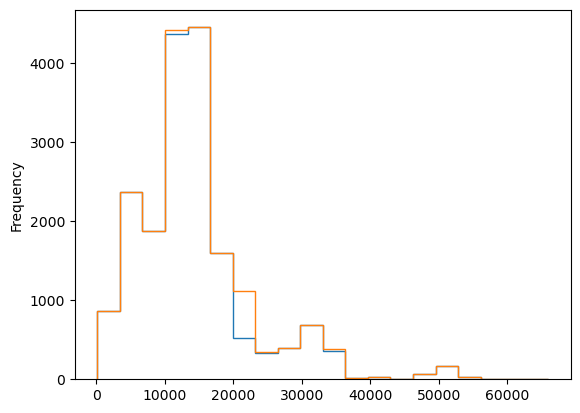

In [20]:
ax = data['city_center_nearest'].plot(kind='hist', bins=20, histtype='step')
median_dist_lo = data.query('locality_name != "Санкт-Петербург"')['city_center_nearest'].mean()

print('До заполнения пропусков : ', data['city_center_nearest'].isna().sum())
data['city_center_nearest'] = data['city_center_nearest'].fillna((data.groupby('locality_name')['city_center_nearest'].transform('median')))
data['city_center_nearest'].plot(kind='hist', bins=20, ax=ax, histtype='step')
print('После заполнения пропусков : ',data['city_center_nearest'].isna().sum())

Как мы видим гистограмма изменилась не сильно, что говорит о том, что мы не исказили изначальные данные.  
Однако, если мы продолжим заполнять пропуски медианой по Л.О., то изменения будут слишком большими.  
Оставшиеся пропуски оставляем как есть.  

#### Заполнение пропусков в столбце ceiling_height

In [21]:
print(data['ceiling_height'].describe())
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] < 20, data['ceiling_height']/10)
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] <= 6, None)
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] > 2, None)

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


Было обнаружено очень большое число пропусков и нереалистичные значения высот потолков:
- значения выше 20 метров были проинтерпретированы как запись в неверных единицах измерения, например, вместо 2.5 метров, записано 25. Причина может заключаться в том, что данные могут собираться в мм или см, при округлении до метров данные изначально записанные в мм будут в 10 раз больше реальных. Маловероятно, что продавец хотел указать высоту потолка меньше 2 метров, поэтому пороговое значение принято в 20 метров. Значения выше 20 метров были поделены на 10;
- значения от 6 метров до 20 метров были отброшены как ошибки, т.к. высота 6 метров возможна в некоторых участках жилых помещений (например в двусветных пространствах), но более 6 метров маловероятно. Значения от 6 до 20 заменены медианой;
- значения меньше 2 метров будут приняты как неверные, отброшены и заменены.  
  
При таком количестве пропусков нельзя просто заменить все данные медианой.  
Предположим, что высота потолка зависит от года постройки, чем ближе к историческому центру, тем выше потолки.  
Проверим это утверждение.

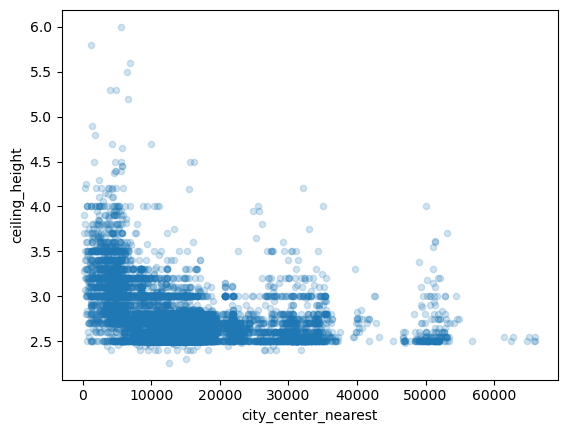

In [22]:
data.plot(x='city_center_nearest', y='ceiling_height', kind='scatter', alpha=0.2);

Действительно, есть зависимость между двумя этими параметрами, чем ближе к центру, тем выше потолки.  
Заполним пропуски в данных в соответствии с этой закономерностью.

In [23]:
data['ceiling_height'] = data['ceiling_height'].astype(float)
data['temp_chuncks'] = pd.qcut(data['city_center_nearest'], 10)
print(data.groupby('temp_chuncks')['ceiling_height'].median())

temp_chuncks
(180.999, 4823.0]     3.10
(4823.0, 8080.0]      3.00
(8080.0, 10713.2]     2.70
(10713.2, 12063.4]    2.60
(12063.4, 13266.0]    2.60
(13266.0, 14673.0]    2.60
(14673.0, 15949.1]    2.60
(15949.1, 18194.0]    2.60
(18194.0, 25796.0]    2.65
(25796.0, 65968.0]    2.60
Name: ceiling_height, dtype: float64


Мы разбили данные по зависимости высоты потолков на 10 срезов и получили медианное значение по каждому срезу.  
Видно что в ближе к центру среднее значение 3.10м, а дальше 10км от центра почти не поднимается выше 2.6м  
В объектах, в которых мы имеем данные по расстоянию до центра, заменим пропуски полученными значениями.

In [24]:
print('Количество пропусков до замены медианами по расстоянию', data['ceiling_height'].isna().sum())
data['ceiling_height'] = data['ceiling_height'].fillna(data.groupby('temp_chuncks')['ceiling_height'].transform('median'))
print('Количество пропусков после замены медианами по расстоянию', data['ceiling_height'].isna().sum())
data = data.drop(columns=['temp_chuncks'], axis=1)

Количество пропусков до замены медианами по расстоянию 9217
Количество пропусков после замены медианами по расстоянию 2174


Количество пропусков значительно сократилось, но осталось ещё 2174.  
Мы можем их заполнить медианой по Л.О., т.к. в СПб пропусков не осталось. Такая замена была бы логичной, но из-за нежелания сильно искажать исходные данные оставшиеся пропуски заполнять не станем.

#### Заполнение пропусков в столбце floors_total

Минимальная этажность здания :  1
Максимальная этажность здания :  60
Медиана этажности зданий :  9


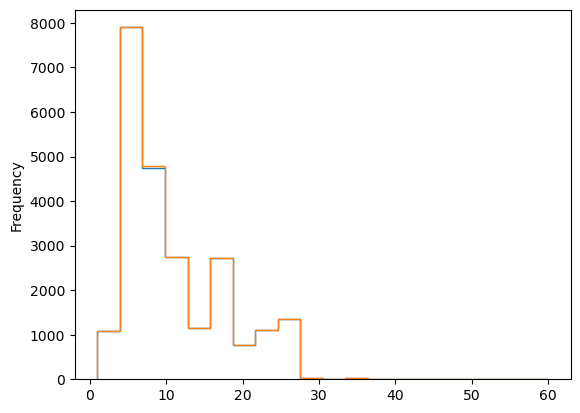

In [25]:
print('Минимальная этажность здания : ', data['floors_total'].sort_values().dropna().min())
print('Максимальная этажность здания : ', data['floors_total'].sort_values().dropna().max())
floors_total_median = int(data['floors_total'].median())
print('Медиана этажности зданий : ', floors_total_median)
ax = data['floors_total'].plot(kind='hist', bins=20, histtype='step')
data['floors_total'] = data['floors_total'].fillna(floors_total_median)
data['floors_total'] = data['floors_total'].mask(data['floors_total'] < data['floor'], data['floor'])
data['floors_total'].plot(kind='hist', bins=20, ax=ax, histtype='step');

Значения выглядят реалистичными, 9-этажные дома в РФ одни из самых распространённых, пропуски заполнены медианой.  
После заполнения пропусков гистограмма изменилась незначительно.

#### Заполнение пропусков в столбце living_area

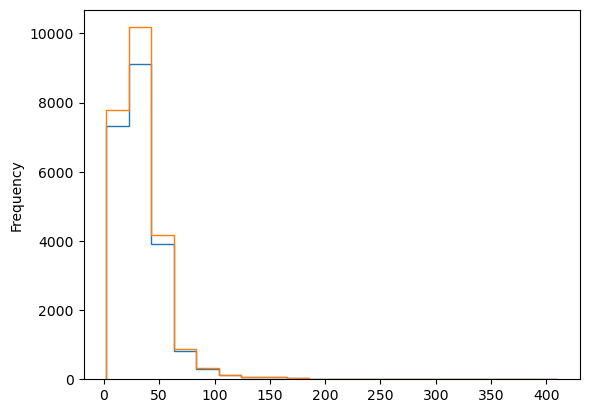

In [26]:
ax = data['living_area'].plot(kind='hist', bins=20, histtype='step')

data['temp_chuncks_2'] = pd.qcut(data['last_price'], 20)
data['temp_val'] = data['living_area']/data['total_area']
data['living_area'] = data['living_area'].fillna(data.groupby('temp_chuncks_2')['temp_val'].transform('median')*data['total_area'])

data['living_area'].plot(kind='hist', bins=20, ax=ax, histtype='step')
data = data.drop(columns=['temp_chuncks_2', 'temp_val'], axis=1)


Значения в диапазоне от 2 до 409,7 кв.м. жилой площади, выглядят реалистично.  
Пропуски заполнены медианной долей жилой площади к общей площади объекта относительно ценовой категории.  
По изменению гистограммы видно, что данные искажены не сильно.

#### Заполнение пропусков в столбце is_apartment

In [27]:
data['is_apartment'] = data['is_apartment'].fillna(False).astype(bool)

Тип апартаментов не слишком популярен в РФ, если продавец его не указал, то вероятнее всего объект не является апартаментами.    
Пропуски заполнены значением `False`

#### Заполнение пропусков в столбце kitchen_area

In [28]:
print(data['kitchen_area'].sort_values().dropna())

20217      1.3
9138       2.0
6262       2.0
21419      2.0
19642      2.0
         ...  
16239     93.2
5358     100.0
2489     100.7
20215    107.0
19540    112.0
Name: kitchen_area, Length: 21421, dtype: float64


В данных есть объект с площадью кухни более 100кв.м.

In [29]:
data.iloc[19540, :]

total_images                               8
last_price                       420000000.0
total_area                             900.0
first_day_exposition     2017-12-06 00:00:00
rooms                                     12
ceiling_height                           2.8
floors_total                              25
living_area                            409.7
floor                                     25
is_apartment                           False
studio                                 False
open_plan                              False
kitchen_area                           112.0
balcony                                 <NA>
locality_name                Санкт-Петербург
airports_nearest                     30706.0
city_center_nearest                   7877.0
parks_around3000                           0
parks_nearest                            NaN
ponds_around3000                           2
ponds_nearest                          318.0
days_exposition                          106
locality_n

При общей площади объекта в 900 кв.м., вероятнее всего в данных нет ошибок.  

В данных множество нулевых значений, в первую очередь определимся с интерпретацией таких аномалий. Нулевые значения могут означать ошибки или квартиры без кухонь. Т.к. в СПб большая доля доля рынка - коммунальные квартиры, пропуски в данных действительно могут означать отсутствие самого кухни. Чтобы это выяснить сравним данные по площадям всех квартир и квартир с пропусками в столбце с кухнями.

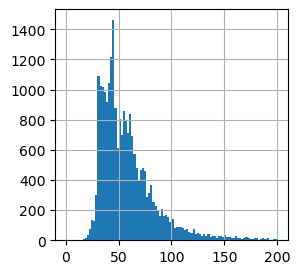

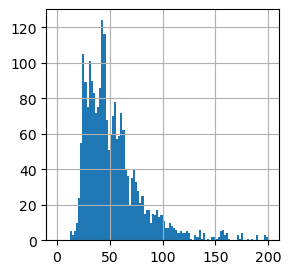

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64
count    2278.000000
mean       56.575680
std        40.863558
min        12.000000
25%        34.000000
50%        46.000000
75%        64.725000
max       500.000000
Name: total_area, dtype: float64


In [30]:
data_temp = data.copy()
data['total_area'].hist(bins=100, figsize=(3, 3), range=(0, 200))
plt.show()
data[data['kitchen_area'].isna()]['total_area'].hist(bins=100, figsize=(3, 3), range=(0, 200))
plt.show()
print(data['total_area'].describe())
print(data[data['kitchen_area'].isna()]['total_area'].describe())


Если вывести гистограмму всех площадей квартир и гистограмму площадей квартир в которых пропущены дынные по кухням, то мы можем увидеть, что последний график несколько смещен влево.  
Вероятно часть из этих квартир действительно без кухонь, а в части значения пропущены. Нужно понять как отфильтровать один случай от другого, т.к. пропусков около 10% и мы не можем заменить данные однородно, чтобы не исказить значения слишком сильно.  
У нас есть данные является ли квартира студией, проверим их.

In [31]:
print(data['kitchen_area'].isna().sum())
print(data['studio'].sum())
print(data[(data['kitchen_area'].isna()) & (data['studio'] == True)]['studio'].sum())
data.loc[data['studio'] == True, 'kitchen_area'] = data.loc[data['studio'] == True, 'kitchen_area'].fillna(0)

2278
149
149


Из 2278 квартир в которых нет кухонь 149 - студии. Заменим данные в этих случаях на 0, т.к. в студиях есть кухни, но невозможно определить их площадь.

Можно предположить, что квартиры в которых нет кухонь и их площадь меньше студии - коммуналки. Для квартир у которых площадь больше, чем средняя площадь студии вероятнее всего значения пропущены.

In [32]:
median_studio_total_area = data.query('studio == True')['total_area'].median()
print('Медианная площадь квартир студий :', median_studio_total_area)
print('Квартиры без кухонь :', data.query('total_area < @median_studio_total_area and kitchen_area.isna()')['total_area'].count())
print('Квартиры с пропущенными значениями : ', data.query('total_area > @median_studio_total_area')['total_area'].count())

Медианная площадь квартир студий : 26.0
Квартиры без кухонь : 142
Квартиры с пропущенными значениями :  23400


Для квартир которые мы принимаем как коммунальные оставляем пропуски в данных.  
В квартирах площадью больше, чем средняя площадь студии, пропуски заполняем медианным значением отношения площади кухни к общей площади объекта.

In [33]:
data['temp_chuncks_3'] = pd.qcut(data['total_area'], 20)
data['temp_kitchen_multiplyer'] = data['kitchen_area']/data['total_area']
data.loc[data['total_area'] > median_studio_total_area, 'kitchen_area'] = data['kitchen_area'].fillna(data.groupby('temp_chuncks_3')['temp_kitchen_multiplyer'].transform('median')*data['total_area'])
data = data.drop(columns=['temp_chuncks_3', 'temp_kitchen_multiplyer'], axis=1)

Проверим как изменилась гистограмма.

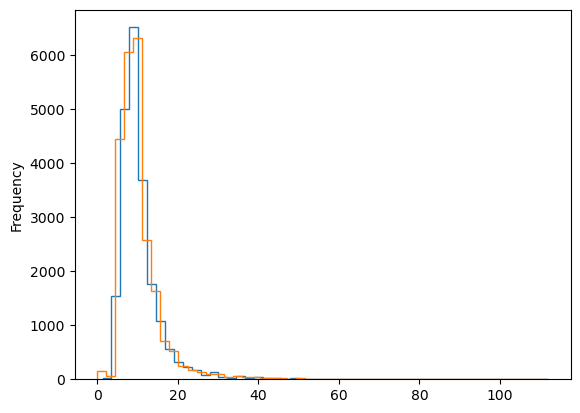

In [34]:
ax = data_temp['kitchen_area'].plot(kind='hist', bins=50, histtype='step')
data['kitchen_area'].plot(kind='hist', bins=50, ax=ax, histtype='step')
plt.show()

Пропуски заполнены, данные не искажены

#### Заполнение пропусков в столбце balcony

In [35]:
data['balcony'] = data['balcony'].fillna(0)

Вероятно что, если данные по количеству болконов отсутствуют, то балконов в квартире нет.  
Пропуски заполняем нулевым значением.

#### Заполнение пропусков в столбце locality_name

Название локации - оставляем неизвестными т.к. восстановить данные не представляется возможным. 

#### Заполнение пропусков в столбце airports_nearest

Посмотрим как соотносятся расположение объекта и расстояние до аэропорта.

In [36]:
city_centers_na = data['airports_nearest'].isna().sum()
city_centers = data['airports_nearest'].count()
center_distance_spb = len(data[(data['airports_nearest'].isna()) & (
    data['locality_name'] == 'Санкт-Петербург')]['airports_nearest'])
center_distance_not_spb = len(data[(data['airports_nearest'].isna()) & (
    data['locality_name'] != 'Санкт-Петербург')]['airports_nearest'])
not_center_distance_spb = len(data[~(data['airports_nearest'].isna()) & (
    data['locality_name'] == 'Санкт-Петербург')]['airports_nearest'])
not_center_distance_not_spb = len(data[~(data['airports_nearest'].isna()) & (
    data['locality_name'] != 'Санкт-Петербург')]['airports_nearest'])

print(f'Если расстояние до аэропорта известно и город Санкт-Петербург - {not_center_distance_spb} значений из {city_centers}.')
print(f'Если расстояние до аэропорта известно и город не Санкт-Петербург - {not_center_distance_not_spb} значений из {city_centers}.')
print(f'Если расстояние до аэропорта неизвестно и город Санкт-Петербург - {center_distance_spb} пропуск из {city_centers_na}.')
print(f'Если расстояние до аэропорта неизвестно и город не Санкт-Петербург - {center_distance_not_spb} пропусков из {city_centers_na}.')


Если расстояние до аэропорта известно и город Санкт-Петербург - 15636 значений из 18157.
Если расстояние до аэропорта известно и город не Санкт-Петербург - 2521 значений из 18157.
Если расстояние до аэропорта неизвестно и город Санкт-Петербург - 85 пропуск из 5542.
Если расстояние до аэропорта неизвестно и город не Санкт-Петербург - 5457 пропусков из 5542.


Пропуски расстояния до аэропорта преимущественно встречаются в Л.О., в СПб всего 85 пропусков.  
При заполнении пропусков мы можем опираться на данные объектов расположенных в тех же населённых пунктах.  
Заполним пропуски в соответствии с расположением объекта, по имени населённого пункта.  

In [37]:
data.groupby('locality_name')['airports_nearest'].median().count()

27

До заполнения пропусков :  5542
После заполнения пропусков :  4837


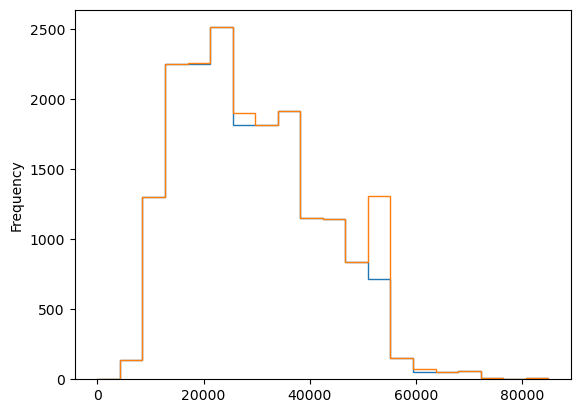

In [38]:
ax = data['airports_nearest'].plot(kind='hist', bins=20, histtype='step')
median_dist_lo = data.query('locality_name != "Санкт-Петербург"')['airports_nearest'].mean()

print('До заполнения пропусков : ', data['airports_nearest'].isna().sum())
data['airports_nearest'] = data['airports_nearest'].fillna((data.groupby('locality_name')['airports_nearest'].transform('median')))
data['airports_nearest'].plot(kind='hist', bins=20, ax=ax, histtype='step')
print('После заполнения пропусков : ', data['airports_nearest'].isna().sum())


Как мы видим гистограмма изменилась не сильно, следовательно мы исказили изначальные данные незначительно.  
Однако, если мы продолжим заполнять пропуски медианой по Л.О. то изменения будут слишком значительными.  
Оставшиеся пропуски мы заполнять не станем, т.к. определить расстояние до эропорта не представляется возможным.

#### Заполнение пропусков в столбце : parks_nearest, parks_around3000, ponds_nearest, ponds_around3000

In [39]:
print(data[(data['parks_nearest'] > 3000) & (data['parks_around3000'] > 0)]['parks_nearest'].count())
print(data[(data['ponds_nearest'] > 3000) & (data['ponds_around3000'] > 0)]['ponds_nearest'].count())

data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

0
0


В parks_around3000 указано количество парков в радиусе 3000м:
- если парков>0, то в parks_nearest указывается ближайший из таких парков;
- если <=0, то поле остаётся пустым.  

При этом часть значений в parks_around3000 заполнены 0, а часть NaN, имеет смысл заполнить пропуски нулями чтобы избежать путаницы.
Значения NaN в столбце parks_nearest оставляем без изменений.

Аналогично с данными по прудам.

#### Заполнение пропусков в столбце days_expositions

Пропуски в days_expositions так и должны остаться пропусками т.к. объявления ещё не сняты.

**Перепроверим результат предобработки:**

In [40]:
initial_data.info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [41]:
print(initial_data.isna().sum())
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64
total_images                 0
last_price                   0
total_area                   0
first_day_exposition         0
rooms                        0
ceiling_height            2174
floors_total                 0
living_area                  0
floor                        0
is_apartment                 0
studio           

В результате проделанной работы типы данных были преведены в соответствие с данными в столбцах. 

Было сокращено количество дубликатов в названиях локаций.  

Были заполнены пропуски в следующих столбцах:  
- этажность постройки;  
- жилая площадь;  
- является ли объект апартаментами;  
- наличие балконов;  
- наличие парков и водоёмов в радиусе 3000 метров.

Было сокращено количество пропусков в столбцах:
- высота потолков;  
- площадь кухонь;  
- расстояние до аэропорта;
- расстояние до центра города.

## Добавление новых признаков

На основе имеющихся данных мы можем добавить новые признаки.

In [42]:
data['sq_m_price'] = (data['last_price']/data['total_area']).round(2)

data['publish_weekday'] = data['first_day_exposition'].dt.weekday

data['publish_month'] = data['first_day_exposition'].dt.month

data['publish_year'] = data['first_day_exposition'].dt.year


def floor_and_floors(ap_floor, bld_floor):
    ap_floor = list(ap_floor)
    bld_floor = list(bld_floor)
    result = []
    for i in range(len(ap_floor)):
        if ap_floor[i] == 1:
            result.append('первый')
        elif ap_floor[i] == bld_floor[i]:
            result.append('последний')
        else:
            result.append('другой')
    return result


data['floor_type'] = (floor_and_floors(data['floor'], data['floors_total']))

data['city_center_nearest_km'] = (data['city_center_nearest']/1000).round().astype('Int64')

В таблицу добавлены:  
- столбец с данными о цене квадратного метра;  
- столбец с днём публикации объявления (0 - понедельник, 1 - вторник и т.д.);  
- столбец с месяцем публикации объявления;  
- столбец с годом публикации объявления; 
- столбец с типом этажа квартиры (значения — «первый», «последний», «другой»);  
- столбец с расстоянием в км до центра города.  

## Исследовательский анализ данных

### Количество комнат

count    23699.000000
mean         2.078948
std          1.066196
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

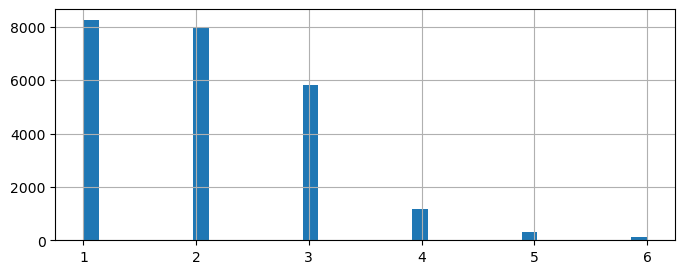

In [43]:
data['rooms'].hist(bins=36, figsize=(8, 3), range=(1, 6))
data['rooms'].describe()

Наиболее распространены однокомнатные квартиры, за ними с небольшим отставанием - двухкомнатные, затем трёхкомнатные и т.д.

### Жилая площадь

count    23699.000000
mean        34.595173
std         22.355808
min          2.000000
25%         19.000000
50%         30.000000
75%         42.192456
max        409.700000
Name: living_area, dtype: float64

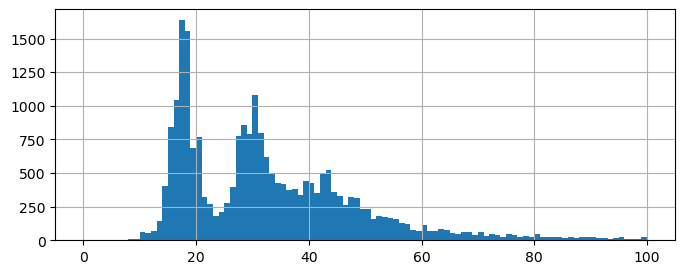

In [44]:
data['living_area'].hist(bins=100, figsize=(8, 3), range=(0, 100))
data['living_area'].describe()

На первый взгляд данные выглядят как несколько совмещённых друг с другом гистограм с распределением близким к нормальному. Возможно это связано с количеством комнат в квартирах. Проверим это предположение.

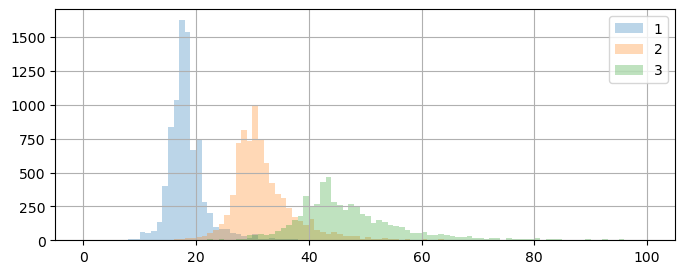

In [70]:
fig, ax = plt.subplots()
for col in [1, 2, 3]:
    data.query('rooms == @col')['living_area'].hist(bins=100, figsize=(8, 3), range=(0, 100), alpha=0.3, ax=ax, label=col)
ax.legend();

Предположение подтвердилось. Действительно, с данными всё в порядке, а три пика - это три типа квартир по числу комнат.

### Общая площадь

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

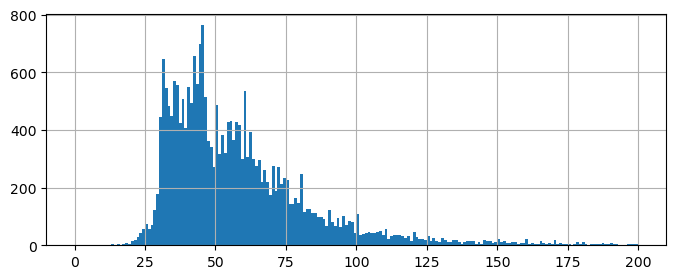

In [46]:
data['total_area'].hist(bins=200, figsize=(8, 3), range=(0, 200))
data['total_area'].describe()

Распределение площадей квартир напоминает кривую Пуассона, но с пилообразной гранью. Логично предположить, что такая форма имеет ту же природу, что и в случае с жилой площадью.
В целом данные выглядят естественно, и 12, и 900 метров - реалистичные площади жилого объекта.

### Площадь кухни

count    23544.000000
mean        10.438038
std          5.845732
min          0.000000
25%          7.000000
50%          9.000000
75%         11.900000
max        112.000000
Name: kitchen_area, dtype: float64

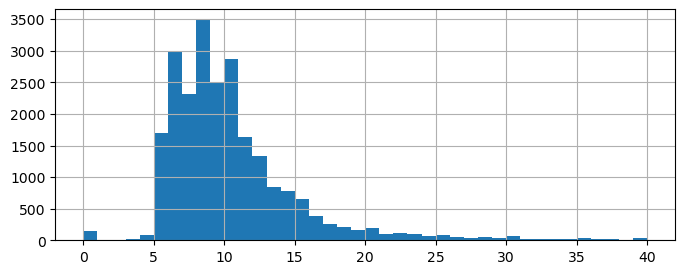

In [47]:
data['kitchen_area'].hist(bins=40, figsize=(8, 3), range=(0, 40))
data['kitchen_area'].describe()

Наиболее распространены кухни площадью в 9 кв. метров.  
Нулевые значения были проставлены в квартирах-студиях.  
Максимальная площадь 112кв.м.

### Цена объекта

count    23699.000000
mean         6.541549
std         10.887013
min          0.012190
25%          3.400000
50%          4.650000
75%          6.800000
max        763.000000
Name: last_price, dtype: float64

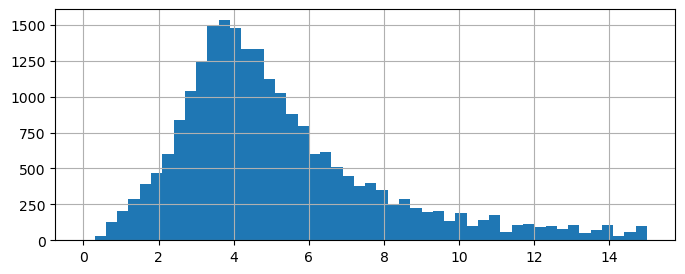

In [48]:
(data['last_price']/1000000).hist(bins=50, figsize=(8, 3), range=(0, 15))
(data['last_price']/1000000).describe()

Цены варьируются в очень широком диапазоне, наиболее распространены сделки между 3.4 и 6.8 млн.р.

### Высота потолков

count    21525.000000
mean         2.718352
std          0.248407
min          2.200000
25%          2.600000
50%          2.600000
75%          2.780000
max          6.000000
Name: ceiling_height, dtype: float64

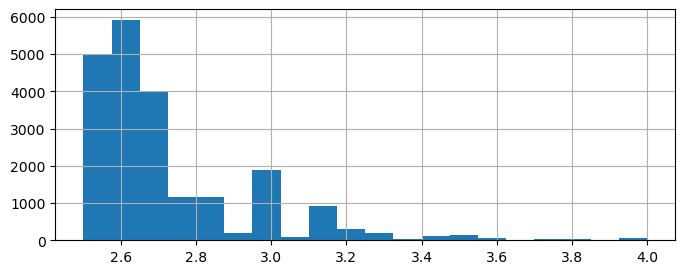

In [49]:
data['ceiling_height'].hist(bins=20, figsize=(8, 3), range=(2.5, 4))
data['ceiling_height'].describe()

Самая распростраённая высота потолка 2.6 метра.  
Высота потолков варьируется в зависимости от года возведения здания и, как следствие, от удалённости от исторического центра города.  
В радиусе пяти километров от центра города медиана высоты потолка составляет 3.1 метра.  

### Этаж квартиры

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

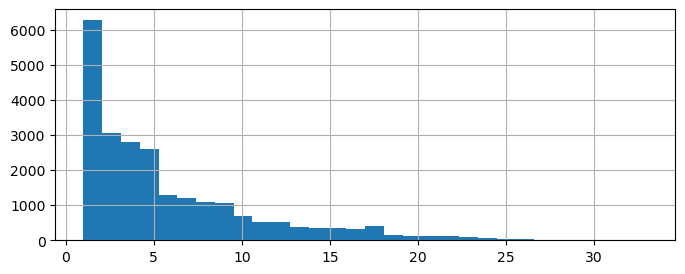

In [50]:
data['floor'].hist(bins=30, figsize=(8, 3))
data['floor'].describe()

Чаще всего квартиры расположены на первом этаже. У любого здания есть первый этаж, а второй и последующие встречаются с меньшей вероятностью.

### Тип этажа квартиры

count      23699
unique         3
top       другой
freq       17404
Name: floor_type, dtype: object

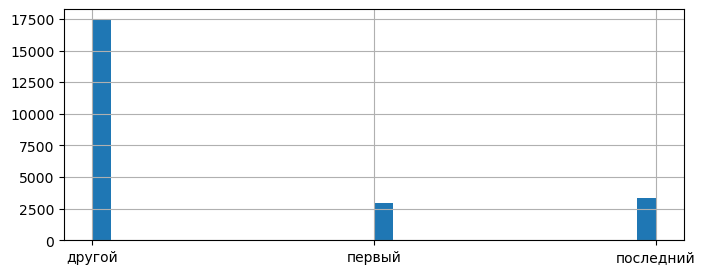

In [51]:
data['floor_type'].hist(bins=30, figsize=(8, 3))
data['floor_type'].describe()

Если сравнить частотность квартир на первом этаже и последнем, то окажется что на первом квартиры продают реже. Связано с это с тем, что на первых этажах часто располагаются встроенные помещения, особенно в новых домах, что в свою очередь связано с изменением нормативной документации в жилищном строительстве.

### Общее количество этажей в доме

count    23699.000000
mean        10.678678
std          6.591239
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

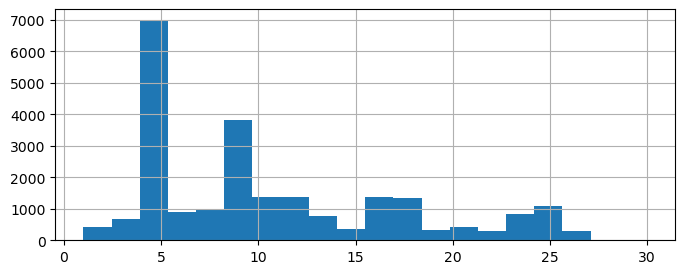

In [52]:
data['floors_total'].hist(bins=20, figsize=(8, 3), range=(1, 30))
data['floors_total'].describe()

Чаще всего встречаются 4-5 этажные дома, затем 9 этажные, также есть пики на 17-18 этажах и на 25ти.
Все эти пики связаны с нормативами в жилищном строительстве: количество лифтов, досягаемость последних этажей с лестницы пожарной машины, наличие в городе пожарного вертолёта и т.д.

### Расстояние до центра города в метрах

count    18862.000000
mean     14458.422967
std       8596.964755
min        181.000000
25%       9488.000000
50%      13266.000000
75%      16771.000000
max      65968.000000
Name: city_center_nearest, dtype: float64

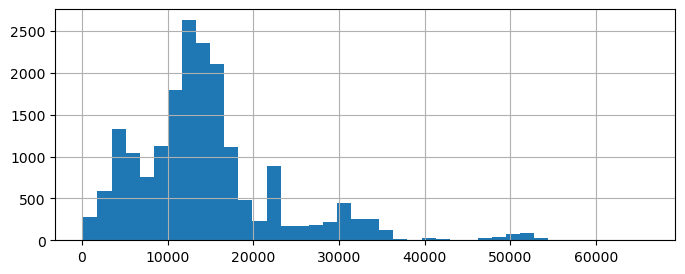

In [53]:
data['city_center_nearest'].hist(bins=40, figsize=(8, 3))
data['city_center_nearest'].describe()

Наибольшее число объектов расположены в диапазоне 9-17 км. В целом график выглядит несколько неоднородно, что можно связать с неоднородностью застройки, пром. зонами, особенностями рельефа и т.д.

### Расстояние до ближайшего аэропорта

count    18862.000000
mean     29534.608101
std      13063.734447
min          0.000000
25%      18846.750000
50%      27179.000000
75%      38755.500000
max      84869.000000
Name: airports_nearest, dtype: float64

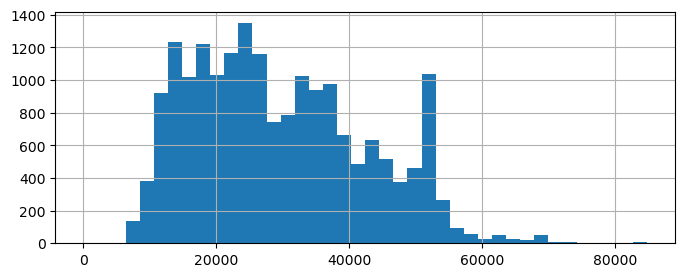

In [54]:
data['airports_nearest'].hist(bins=40, figsize=(8, 3))
data['airports_nearest'].describe()

Как и в случаем гистограмы растояний до центра график выглядит неоднородно. Но однозначно можно сказать что основная масса обектов расположены в пределах 19-38 км.

### Расстояние до ближайшего парка

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

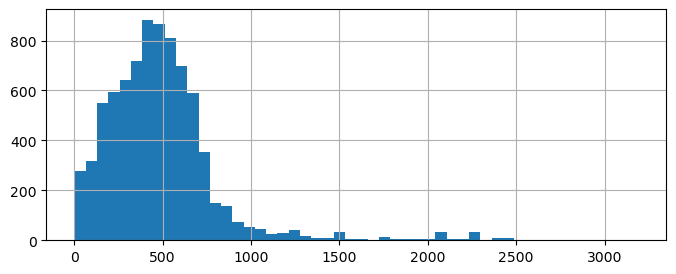

In [55]:
data['parks_nearest'].hist(bins=50, figsize=(8, 3))
data['parks_nearest'].describe()

В этом столбце мы оставили много пропусков т.к. учитаны только парки расстояние до которых менее 3000м.  
Однако, по гистограмме видно, что основная масса объектов расположены в 300-600 метрах от парка, а на расстоянии более полутора километров парки встречаются крайне редко, что говорит в пользу того, что система парков в СПб спроектирована эффективно.

### День и месяц публикации объявления

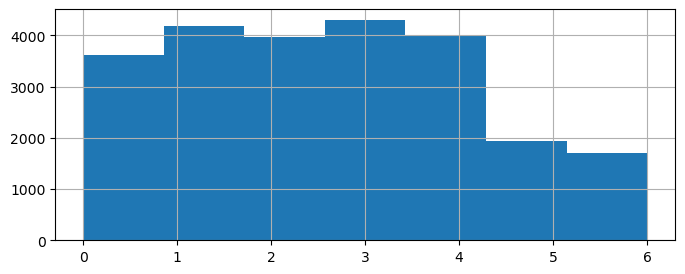

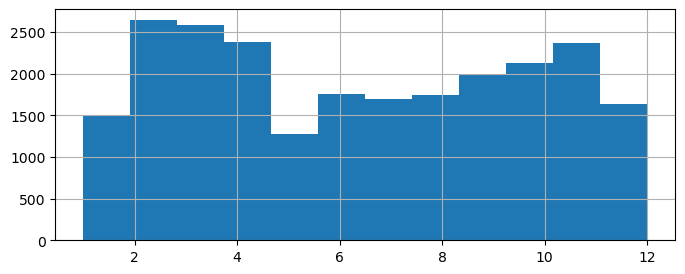

In [72]:
data['publish_weekday'].hist(bins=7, figsize=(8, 3))
plt.show();
data['publish_month'].hist(bins=12, figsize=(8, 3));

Наименьшее число публикаций приходится на выходные дни, а наибольшее на период со вторника по пятницу.
По месяцам различия также значительны, наименьшая активность приходится на декабрь, январь (что легко обяснить) и май.  
Наибольшая активность с февраля по апрель.

**В результате исследовательского анализа данных** были изучены и проинтепретированы следующие данные об объектах недвижимости:
- количество комнат;
- жилая площадь;
- общая площадь;
- площадь кухни;
- цена объекта;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры;
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

## Время продажи квартиры

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

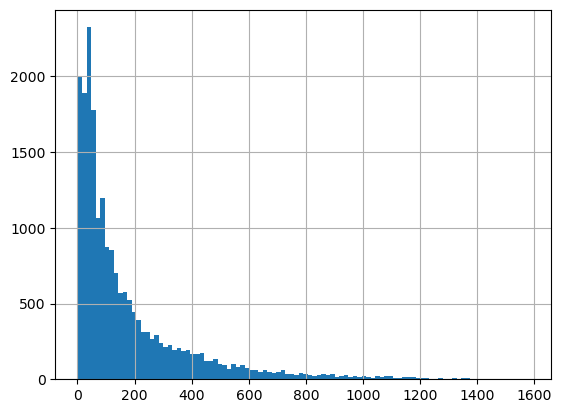

In [57]:
data['days_exposition'].hist(bins=100)
data['days_exposition'].describe()

Продажа обычно занимает 95 дней.  
Быстрыми можно считать продажи до 45 дней.  
Необычно долгими более 232 дней.

## Какие факторы больше всего влияют на общую стоимость объекта?

Оценим признаки по коэффециенту корреляции и диаграмме рассеяния.

### Общая площадь

0.6536750579657251

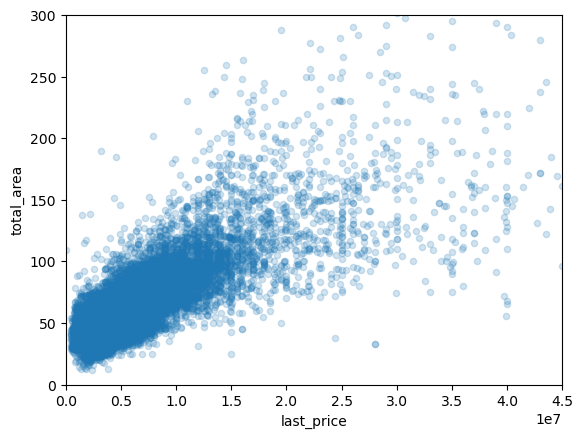

In [58]:
data.plot(x='last_price', y='total_area', kind='scatter', ylim=(0, 300), xlim=(0, 45000000), alpha=.2)
data['last_price'].corr(data['total_area'])

Коэффициент Пирсона в 0,65 и график рассеяния указывают на то, что есть положительная корреляция между общей площадью объекта и его стоимостью.

### Жилая площадь

0.5855842461102636

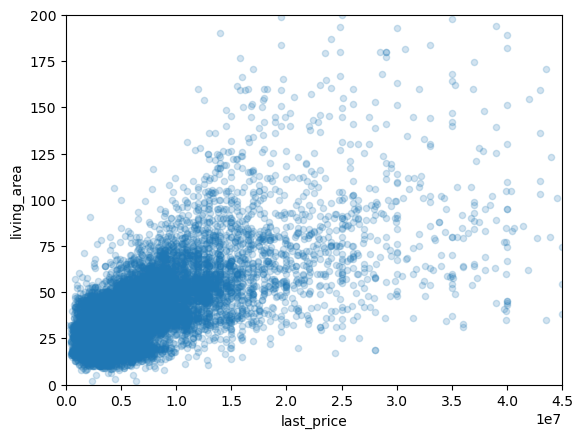

In [59]:
data.plot(x='last_price', y='living_area', kind='scatter', ylim=(0, 200), xlim=(0, 45000000), alpha=.2)
data['last_price'].corr(data['living_area'])

Между жилой площадью объекта и его стоимостью есть положительная корреляция. Коэффициент Пирсона в 0.58, несколько меньше, чем между общей площадью и ценой.

### Площадь кухни

0.4917418606033781

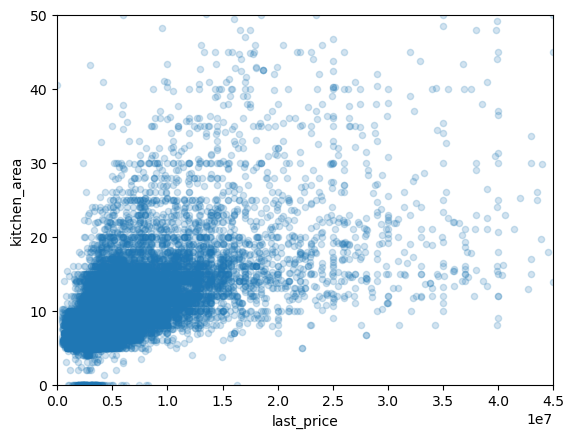

In [60]:
data.plot(x='last_price', y='kitchen_area', kind='scatter', ylim=(0, 50), xlim=(0, 45000000), alpha=.2)
data['last_price'].corr(data['kitchen_area'])


Между площадью кухни и стоимостью объекта также есть положительная корреляция. Коэффициент Пирсона в 0.49, что меньше, чем коэффициент зависимости цены от общей площади и жилой площади.

### Количество комнат

(-1000000.0, 100000000.0)

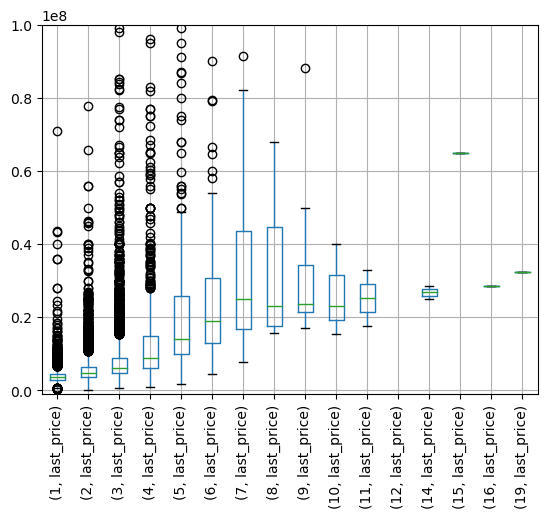

In [61]:
data1 = data.groupby('rooms')
fig, ax = plt.subplots()
data1.boxplot(ax=ax, column=['last_price'], subplots=False, rot=90).set_ylim(-1000000, 100000000)


Цена объекта зависит от количества комнат, причём прямая зависимость прослеживается от 1 до 8 комнат, а более 8 комнат виден даже небольшой спад цен.

### Тип этажа

(-1000000.0, 13000000.0)

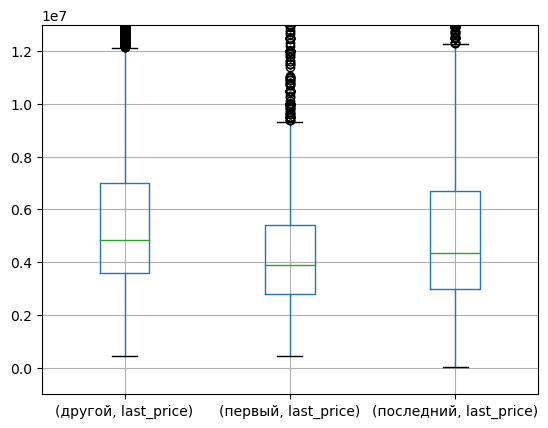

In [62]:
data1 = data.groupby('floor_type')
fig, ax = plt.subplots()
data1.boxplot(ax=ax, column=['last_price'], subplots=False).set_ylim(-1000000, 13000000)


По типу этажей цены на объекты расположились в следующем порядке по возрастанию: первые этажи, последние этажи, другие.

### Дата размещения

#### День недели

(-1000000.0, 13000000.0)

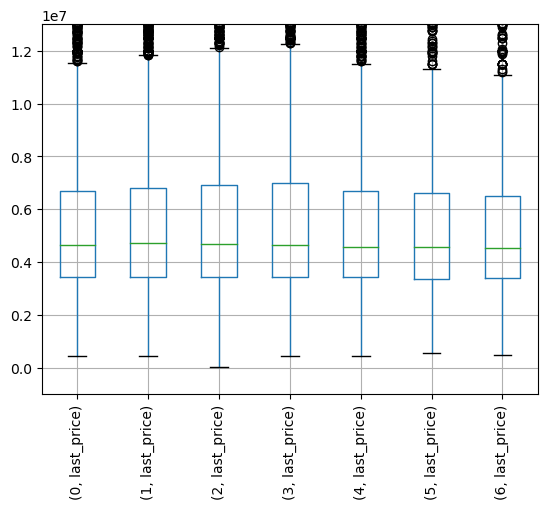

In [63]:
data1 = data.groupby('publish_weekday')
fig, ax = plt.subplots()
data1.boxplot(ax=ax, column=['last_price'], subplots=False, rot=90).set_ylim(-1000000, 13000000)

К середине недели цены на объявления немного выше, чем в начале и на выходных.  
Это можно связать с тем, что продавцы более дорогой недвижимости чаще обращаются к риэлторам, которые зачастую включают стоимость своих услуг в цену объекта, и которые не работают по выходным, а продавцы с более дешевой недвижимостью размещают объявления самостоятельно, в том числе и в выходные дни.

#### Месяц

(-1000000.0, 13000000.0)

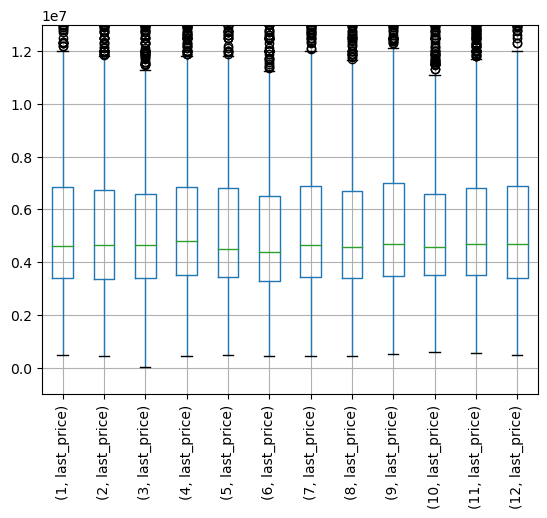

In [64]:
data1 = data.groupby('publish_month')
fig, ax = plt.subplots()
data1.boxplot(ax=ax, column=['last_price'], subplots=False, rot=90).set_ylim(-1000000, 13000000)

Цены отличаются месяц от месяца, но какой-либо зависимости выявить не удалось.

#### Год

(-1000000.0, 30000000.0)

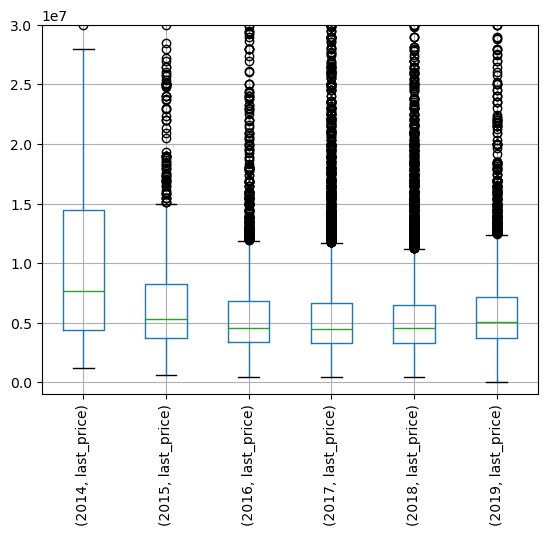

In [65]:
data1 = data.groupby('publish_year')
fig, ax = plt.subplots()
data1.boxplot(ax=ax, column=['last_price'], subplots=False, rot=90).set_ylim(-1000000, 30000000)

После 2014 года цены на недвижимость снижались в течении двух лет, затем стабилизировались.

На стоимость квартиры влияют следующие параметры:  
- общая площадь;
- жилая площадь;
- площадь кухни;
- количество комнат;
- тип этажа.

Также есть зависимость цены от года публикации объявления.  
Незначительная корреляция наблюдается между ценой и днём недели.  
Между ценой и месяцем корреляции не обнаружено.

## Населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [66]:
top_cities_list = (data.groupby('locality_name').count().sort_values(by='total_area', ascending=False).index[:10])
print('Топ-10 населённых пунктов с наибольшим числом объявлений :')
[print(i) for i in top_cities_list];

Топ-10 населённых пунктов с наибольшим числом объявлений :
Санкт-Петербург
Мурино
Кудрово
Шушары
Всеволожск
Пушкин
Колпино
Парголово
Гатчина
Выборг


In [67]:
cities_and_prices = {}
for i in top_cities_list:
    price = data.query('locality_name == @i')['last_price'].mean()
    area = data.query('locality_name == @i')['total_area'].mean()
    cities_and_prices[price/area] = i

min_price = min(list(cities_and_prices.keys()))
max_price = max(list(cities_and_prices.keys()))

print(
    f'Минимальная цена за квадратный метр в городе {cities_and_prices[min_price]} : {min_price}')
print(
    f'Максимальная цена за квадратный метр в городе {cities_and_prices[max_price]} : {max_price}')

Минимальная цена за квадратный метр в городе Выборг : 57898.14210869611
Максимальная цена за квадратный метр в городе Санкт-Петербург : 124514.62137809927


Из 10 населённых пунктов с наибольшим числом объявлений самая низкая цена за квадратный метр в Выборге, а самая высокая в Санкт-Петербурге.

## Корреляция стоимости объектов и расстояния до центра города

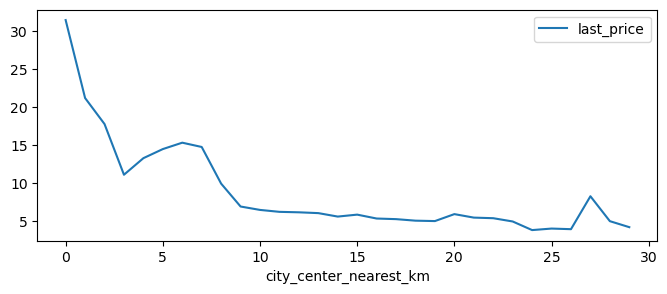

In [68]:
max_dist = data.query('locality_name == "Санкт-Петербург"')['city_center_nearest_km'].max()
km_to_price = data.query('locality_name == "Санкт-Петербург"').pivot_table(
    index='city_center_nearest_km', 
    values='last_price', 
    aggfunc=('mean')
)/1000000

km_to_price.plot(figsize=(8, 3));

In [69]:
km_to_price

,last_price
city_center_nearest_km,
0,31.449116
1,21.206721
2,17.788320
3,11.126581
4,13.304280
5,14.499121
6,15.338418
7,14.775153
8,9.957717


Между расстоянием до центра и стоимостью объекта есть зависимость.  
Чем ближе к центру города, тем дороже объект.  

## Общий вывод

На первом этапе были бегло просмотрены данные и оценены дальнейшие действия по их предобработке.  
На этапе предобработки данных проведены следующие операции над данными:  
- преобразование типов данных;  
- поиск и замена дубликатов;  
- заполнение пропусков;  
- корректировка и интерпретация аномальных данных.  

Далее были добавлены новые столбцы с расчётными данными, которые в дальнейшем использовались в анализе.  
На этапе исследовательского анализа данных были изучены и проинтерпретированы основные параметры объектов, а также время продажи объектов.  
  
На следующем, завершающем этапе, были обнаружены зависимости между рядом параметров объектов и их стоимостью, также была изучена корреляция между стоимостью объектов и расстоянием до центра.  
Наиболее ценным является обнаружение зависимости между ценой и следующими параметрами: общей площадью, жилой площадью, площадью кухни, числом комнат и расстоянием до центра города.  

Результаты работы могут быть полезны при оценке отклонения стоимости объектов от средних значений на рынке, при оценке новых объектов недвижимости и построении системы рекомендаций по оценке объекта.